## ИАД: Введение в анализ данных – 2021

## Семинар 14: Бустинг, часть 1

### 1. Бустинг: идея подхода

На прошлом семинаре мы рассмотрели один из способов построения композиций моделей – бэггинг. Вспомним, что основная идея бэггинга состоит в том, чтобы агрегировать ответы большого числа независимых переобученных моделей, имеющих низкое смещение и большую дисперсию. Агрегация позволяет добиться значительного снижения дисперсии при сохранении низкого смещения. Бэггинг над деревьями, в котором при построении каждого дерева при разбиениях используются случайные подмножества признаков, называется случайным лесом.

На этом семинаре мы рассмотрим альтернативный бэггингу подход к построению композиции моделей – бустинг. Идея бустинга состоит в том, чтобы построить последовательность **базовых моделей**, каждая из которых **исправляет ошибки предыдущих**. Как и в случае бэггинга, ответ композиции получается агрегированием ответов базовых моделей.

#### 1.1 Простой пример для понимания идеи. 

Пусть мы решаем задачу регрессии на тренировочной выборке $(X, y)$. Мы обучаем модель $a(X)$, которая является композицией базовых моделей $b_n(X)$. Будем считать, что композиция строится простым суммированием ответов базовых моделей:

$$
a(X) = \sum_{n = 1}^{k} b_n(X).
$$

В качестве базовой модели будем использовать решающее дерево глубины один (decision stump). 

**Важное замечание.** Считается, что одним из наиболее сильных и универсальных методов машинного обучения на данный момент является бустинг над деревьями, и во многих туториалах в Интернете рассматривается именно бустинг над деревьями. Следуя этой традиции (а также потому что при использовании деревьев картинки получаются более наглядными), в этом примере мы также рассмотрим бустинг над деревьями. Однако важно понимать, что бустинг – это подход, который может строиться над любыми моделями, на что мы также обратим внимание ниже.

Будем решать задачу при помощи минимизации среднеквадратичной ошибки:

$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} (a(x_i) - y_i)^2 \to \min_a.
$$

В этом примере будем работать только с обучающей выборкой. Для построения композиции непосредственно используем идею бустинга.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

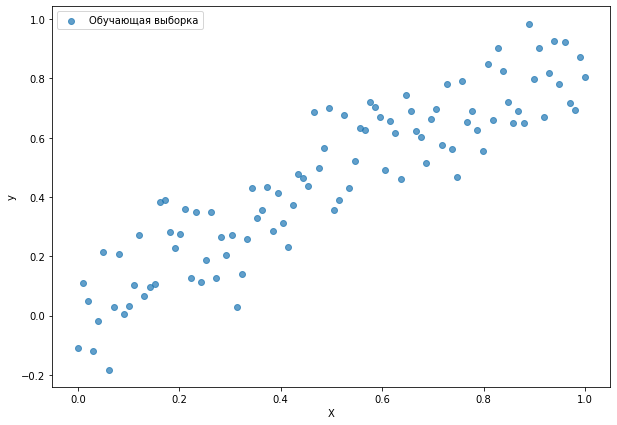

In [14]:
# Генерация выборки
np.random.seed(123)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size = N)

# Функция для визуализации выборки и предсказаний
def plot_sample_model(X, y, plot_predictions = False, y_pred = None, y_pred_label = None, loss = 'mse'):
    plt.figure(figsize = (10, 7))
    plt.scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
    if plot_predictions:
        plt.plot(X, y_pred, label = y_pred_label, c = 'r')
        if loss == 'mse':
            plt.title('MSE: ' + str(mean_squared_error(y, y_pred)))
        elif loss == 'mae':
            plt.title('MAE: ' + str(mean_absolute_error(y, y_pred)))
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend();
    
plot_sample_model(X, y, plot_predictions = False)

**Шаг 0.** Имеем пустую композицию решающих деревьев $a(X) = \{\}$.

In [15]:
a = 0

**Шаг 1.** Обучим первое решающее дерево $DT_1$ и включим его в композицию: $a^{(1)}(X) = DT_1$. Получим предсказания композиции на обучающей выборке.

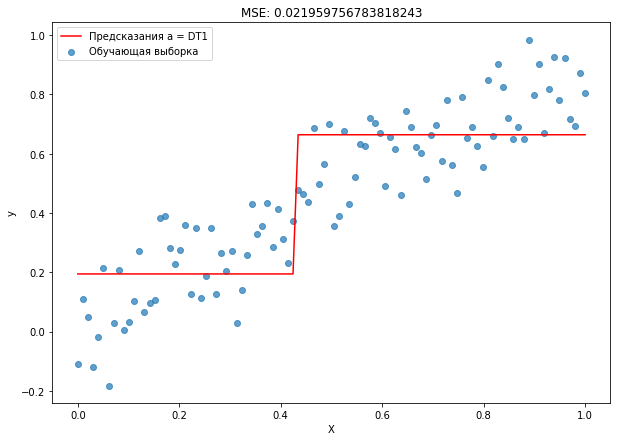

In [16]:
from sklearn.tree import DecisionTreeRegressor

# TODO: обучите решающее дерево глубины 1 и сделайте предсказания на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth=1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# TODO: включите предсказания первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1')

**Шаг 2.** В качестве ошибок композиции будем использовать **остатки** – 
расстояния от предсказаний композиции до истинных ответов:

$$
s^{(1)}(X) = y - a^{(1)}(X)
$$

Заметим, что $MSE$ – это усреднённая сумма квадратов остатков и что остатки являются естественным выражением ошибки: если мы прибавим остатки к ответам модели, то добьёмся нулевой среднеквадратичной ошибки. Таким образом, логично строить следующую модель так, чтобы она хорошо предсказывала остатки композиции: если мы прибавим предсказания второй модели (предсказанные остатки) к предскзазаниям первой, то добьёмся снижения ошибки.

In [17]:
# TODO: рассчитайте остатки  
s1 = y - a

**Шаг 3.** Обучим второе решающее дерево $DT_2$, предсказывающее остатки. Добавим предсказания второго дерева в композицию: $a^{(2)}(X) = DT_1 + DT_2$. Получим предсказания композиции на обучающей выборке.

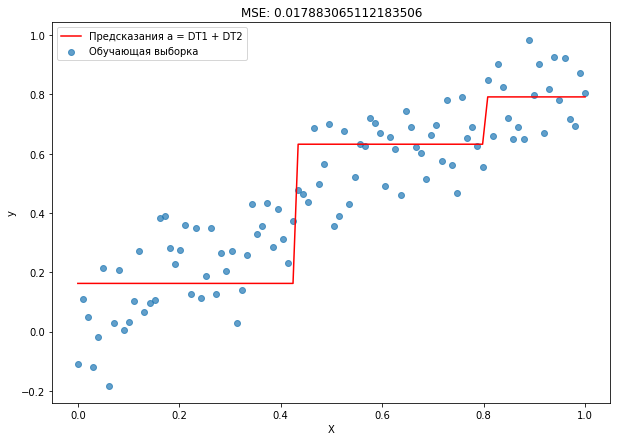

In [18]:
# TODO: обучите второе решающее дерево глубины 1, предсказывающее остатки
dt2 = DecisionTreeRegressor(max_depth=1)
dt2.fit(X, s1)

# TODO: сделайте предсказания на обучающей выборке
dt2_pred = dt2.predict(X)

# TODO: включите предсказания второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1 + DT2')

Как мы видим, решающая поверхность стала более сложной, и теперь она более точно приближает обучающую выборку. 

**Шаги 4 – ...** Повторяем шаги 2-3, пока не надоест.

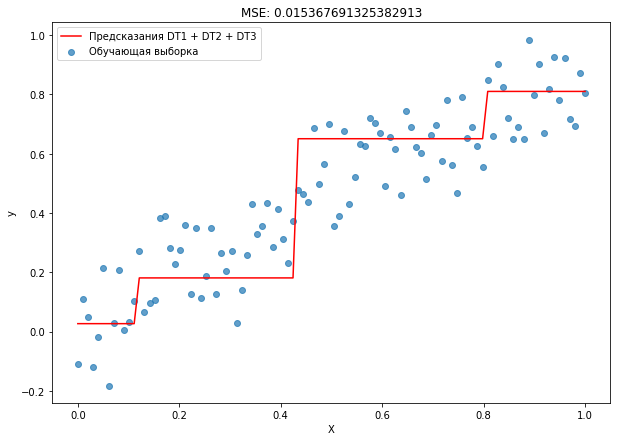

In [19]:
# TODO: рассчитайте остатки
s2 = y - a

# TODO: обучите третье решающее дерево глубины 1, предсказывающее остатки
dt3 = DecisionTreeRegressor(max_depth = 1)
dt3.fit(X, s2)

# TODO: сделайте предсказания на обучающей выборке
dt3_pred = dt3.predict(X)

# TODO: включите предсказания третьего дерева в композицию (простым суммированием)
a += dt3_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания DT1 + DT2 + DT3')

Как мы видим, при добавлении базовых моделей решающая поверхность становится более сложной и всё точнее приближает обучающую выборку.

**Важный момент:** заметим, что при обучении очередной базовой модели композиция предыдущего шага считается фиксированной. Это означает, что обучение новой базовой модели не влияет на уже обученные модели, содержащиеся в композиции.

#### 1.2 Бустинг над разными моделями.

При помощи функции `plot_boosting_results()` можно визуализировать решающие поверхности композиции, очередной базовой модели и остатки при добавлении базовых моделей. 

**Задание:** посмотрите, как выглядят решающие поверхности композиции, если в качестве базовой модели использовать
- решающее дерево
- линейную регрессию
- `kNN`-регрессор
- `SVR`.

In [20]:
def plot_boosting_results(base_estimator, n_estimators, X, y):
    
    fig, ax = plt.subplots(n_estimators, 3, figsize = (20, n_estimators * 5))
    
    # Остатки
    resid = []
    resid.append(y)
    
    # Предсказания моделей
    y_pred = []
    
    for i in range(n_estimators):
        # Обучение очередной базовой модели
        base_estimator.fit(X, resid[-1])
        
        # Предсказание базовой модели
        y_pred.append(base_estimator.predict(X))
        
        # Вычисление предсказания композиции
        a = np.sum(y_pred, axis = 0)
        
        # Вычисление остатка
        resid.append(y - a)
        
        # Предсказания композиции
        ax[i, 0].scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
        ax[i, 0].plot(X, a, c = 'red', lw = 3, label = 'Число деревьев: ' + str(i + 1))
        ax[i, 0].set_title('MSE: ' + str(mean_squared_error(y, a)))

        # Предсказания очередной модели
        ax[i, 1].scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
        ax[i, 1].plot(X, y_pred[-1], c = 'red', lw = 3)
        ax[i, 1].set_title('Предсказания модели ' + str(i + 1))
        
        ax[i, 2].scatter(X, resid[-1], alpha = 0.7, marker = 'v', c = 'orange')
        ax[i, 2].set_title('Остатки')
        
        ax[i, 0].legend()

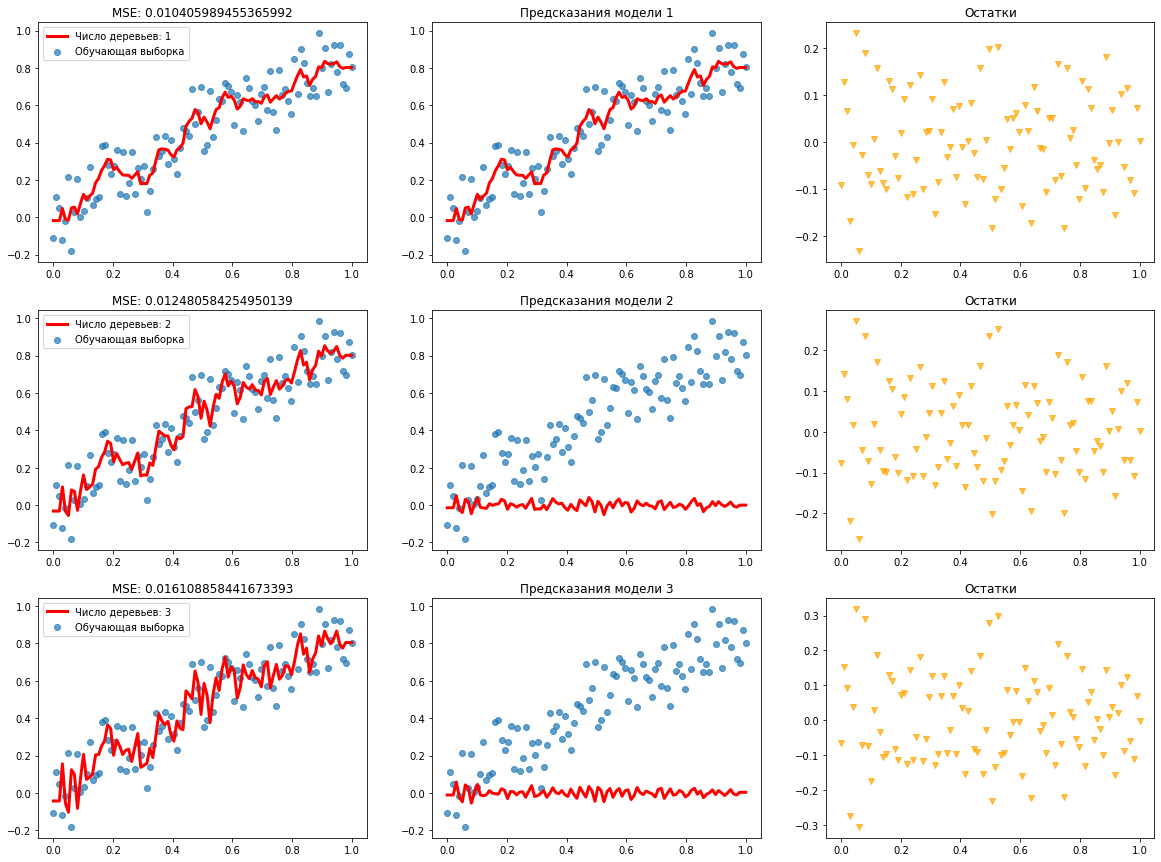

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# TODO: используйте разные модели
plot_boosting_results(KNeighborsRegresso r(), n_estimators = 3, X = X, y = y)

### 2. Градиентный бустинг

Заметим, что в примере выше использование остатков как меры ошибки модели было оправданным, так как остатки непосредственно участвуют в расчёте $MSE$. Попробуем обобщить идею использования остатков на произвольную функцию потерь.

Будем решать ту же задачу, что и выше, но с использованием произвольной функции потерь $L(\cdot)$. Предположим, что каким-то образом мы уже обучили $N$ базовых моделей и построили композицию $a^{(N)}(X)$. Как построить $(N+1)$-ю базовую модель?

Заметим, что мы хотим выбрать $(N+1)$-ую базовую модель так, чтобы как можно сильнее уменьшить ошибку:

$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} L[y_i, a^{N}(x_i) + b^{(N+1)}(x_i)] \to \min_{b^{(N+1)}},
$$

где $b^{(N+1)}(x_i)$ – предсказания новой базовой модели. Теперь заметим, что так как и $y_i$, и $a^{N}(x_i)$ фиксированы (обсуждали выше), то в сущности нам нужно найти числа $b^{(N+1)}(x_i) = s_i^{(N)}$, которые сильнее всего уменьшили бы функцию потерь:


$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} L[y_i, a^{N}(x_i) + s^{(N)}_i] \to \min_{s^{(N)}_i}.
$$

**Замечание.** Заметьте, что теперь мы ищем просто числа $s^{(N)}_i$, которые сильнее всего уменьшили бы функцию.

После изучения градиентного спуска мы знаем, что вектор чисел, сильнее всего уменьшающих какую-то функцию – это антиградиент этой функции. Таким образом, в качестве чисел $s_i^{(N)}$ следует взять

$$
s_i^{(N)} = -\dfrac{\partial L(y, p)}{\partial p}
$$

в точке $p = a^{(N)}(x_i)$, то есть антиградиент функции потерь в точке ответов уже построенной композиции. 

**Чек-пойнт.** Убедитесь, что вы понимаете, какие **числа**, нужно взять, чтобы решить задачу. 

Итак, мы выяснили, какие числа нужно взять для уменьшения функции потерь на **обучающей выборке**. Вспомним, что мы определяли эти числа как $b^{(N+1)}(x_i) = s_i^{(N)}$, то есть ответы очередной базовой модели. Таким образом, нам нужно обучить очередную базовую модель так, чтобы она хорошо приближала антиградиент функции потерь в точке ответов уже построенной композиции – а это хорошо известная нам задача обучения с учителем. Обычно она решается путём минимизации $MSE$:

$$
b^{(N+1)}(x) = \arg\min_b \sum_{i = 1}^{\ell} (b(x_i) - s_i^{(N)})^2.
$$

**Важный момент:** заметим, что задача, описанная выше – это не изначальная задача! В этом и состоит магия градиентного бустинга: мы можем использовать любую функцию потерь, через неё вывести $s_i^{(N)}$, а затем просто решать задачу приближения при помощи $MSE$!

#### 2.1 Продолжение простого примера для понимания идеи.

Повторим шаги из примера 1.1, используя градиентный бустинг, чтобы лучше разобраться в идее и провести параллели. Вспомним, что мы решали задачу регрессии при помощи минимизации $MSE$.

Нулевой и первый шаги в этих примерах совпадают.

**Шаг 0.** Имеем пустую композицию решающих деревьев $a(X) = \{\}$.

In [61]:
a = 0

**Шаг 1.** Обучим первое решающее дерево $DT_1$ и включим его в композицию: $a^{(1)}(X) = DT_1$. Получим предсказания композиции на обучающей выборке.

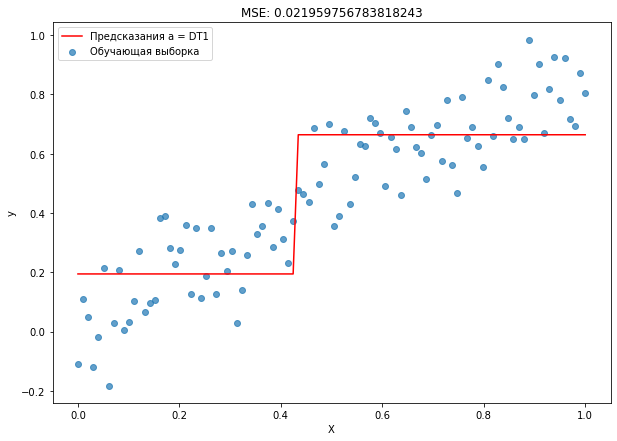

In [62]:
from sklearn.tree import DecisionTreeRegressor

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1')

**Шаг 2.** В примере 1.1 на этом шаге мы рассчитывали остатки. Здесь же мы должны рассчитать антиградиент функции потерь в точке ответов уже построенной композиции.

**Задание:** вычислите градиент $MSE$

$$
L(y, p) = \dfrac{1}{2} \sum_{i = 1}^{\ell} (y_i - p_i)^2
$$

по $p_i$ в точке $p_i = a(x_i)$.

**Решение:** 

$$
\dfrac{\partial L(y, p)}{\partial p_i} = -(y_i - p_i) = \{p_i = a(x_i)\} = -(y_i - a(x_i)).
$$

Таким образом, антиградиент функции потерь равен:

$$
s_i = - (-(y_i - a(x_i))) = y_i - a(x_i),
$$

то есть в точности остаток в том виде, как мы определяли выше. 

Таким образом, использование градиентного бустинга, если целевая функция – $MSE$, эквивалентно процедуре расчёта остатков, как мы это делали в примере 1.1, а сами остатки совпадают с антиградиентами $s_i$!

In [24]:
# TODO: рассчитайте антиградиент  
s1 = y - a

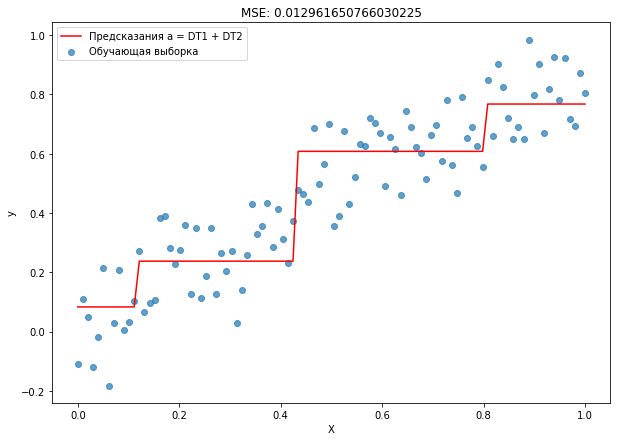

In [25]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1 + DT2')

**Шаг 3 и далее.** Далее нам нужно обучить базовую модель, предсказывающую $s_i$. Но так как $s_i$ совпадают с остатками, этот и дальнейшие шаги будут совпадать с примером 1.1.

### 3. Функции потерь градиентного бустинга для регрессии и классификации

#### 3.1 Регрессия.

В задачах регрессии в качестве целевой функции для композиции обычно берутся:

1. $MSE$, которую мы рассматривали ранее.

2. $MAE$:

$$
MAE(y, p) = \dfrac{1}{\ell} \sum_{i = 1}^{\ell} |y_i - p_i|
$$

Попробуем сделать шаг градиентного бустинга, используя в качестве функции потерь $MAE$.

**Задание:** рассчитайте $s_i$ для $MAE$.

**Решение:** $s_i^{(N)} = -\mathrm{sign}(a^{(N-1)}(x_i) - y_i)$.

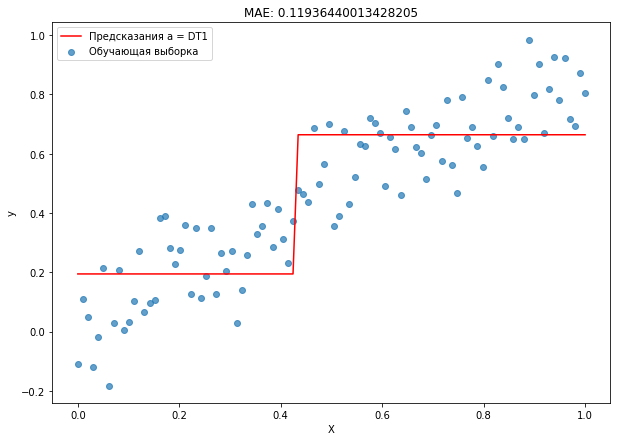

In [26]:
# Инициализация
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1', loss = 'mae')

In [91]:
# TODO: рассчитайте антиградиент  
s1 = ...

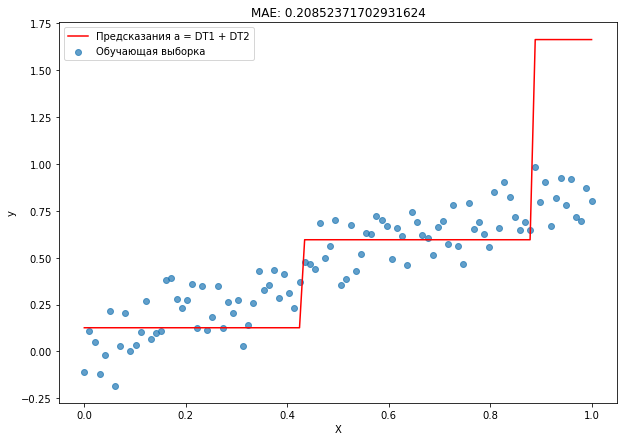

In [92]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, 
                  y_pred_label = 'Предсказания a = DT1 + DT2', loss = 'mae')

Заметим, что $MAE$ увеличилась, а решающая поверхность имеет "виток", уходящий за пределы обучающей выборки. Эту проблему мы решим позже.

#### 3.2 Классификация.

В задачах бинарной классификации обычно используется логистическая функция потерь, с которой мы уже сталкивались в логистической регрессии.

$$
L(y, p) = \log(1 + e^{-yp}).
$$

**Бонусное задание:** покажите, что в этом случае антиградиенты можно вычислить по формуле

$$
s^{(N)}_i = \dfrac{y_i}{1 + e^{y_ia^{(N-1)}(x_i)}}
$$

Попробуем сделать шаг градиентного бустинга в задаче бинарной классификации с логистической функцией потерь.

In [27]:
from sklearn.datasets import load_iris

# Загрузка данных
data = load_iris()
X = data['data']
y = data['target']

# Перекодируем в задачу бинарной классификации
y[y == 2] = 1
set(y)

{0, 1}

In [28]:
# Инициализация
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

In [29]:
def log_loss(y, y_pred):
    # TODO: реализуйте логистическую функцию потерь
    return np.log(1 + np.exp(- y * y_pred)).mean()

In [30]:
# Вычисление ошибки для одного дерева
log_loss(y, a)

0.439890185198797

In [31]:
# TODO: рассчитайте антиградиент  
s1 = y / (1 + np.exp(y * a))

In [32]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

In [33]:
# Вычисление ошибки для двух деревьев
log_loss(y, a)

0.39621023915529535

### 4. Особенности градиентного бустинга

#### 4.1 Построение композиции.

В примерах выше мы строили композицию моделей простым суммированием. Понятно, что в общем виде можно строить взвешенную сумму базовых моделей:

$$
a(X) = \sum_{n = 1}^{k} w_nb_n(X),
$$

где коэффициенты $w_n$ можно подобрать, например, при помощи градиентного спуска в задаче 

$$
w_n = \arg\min_{w} \sum_{i = 1}^{\ell} L(y_i, a^{(N-1)}(x_i) + w \times b_N(x_i)),
$$

что имеет смысл, так как $b_N(x_i)$ уже обучена и фиксирована.

**Замечание:** длина шага является одним из ключевых параметров градиентного бустинга, и может очень сильно повлиять на его производительность. Подробнее об этом [здесь](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/).

В нашем случае подбор правильного коэффициента поможет решить увеличение MAE в примере 3.1. 

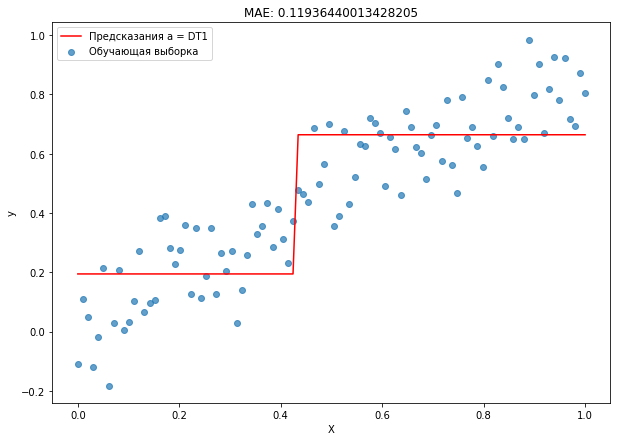

In [49]:
# Инициализация
np.random.seed(123)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size = N)
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1', loss = 'mae')

In [50]:
# Вычисление антиградиента 
s1 = -np.sign(a - y)

In [51]:
# TODO: подберите (угадайте) вес так, чтобы уменьшить MAE
w = 0.3

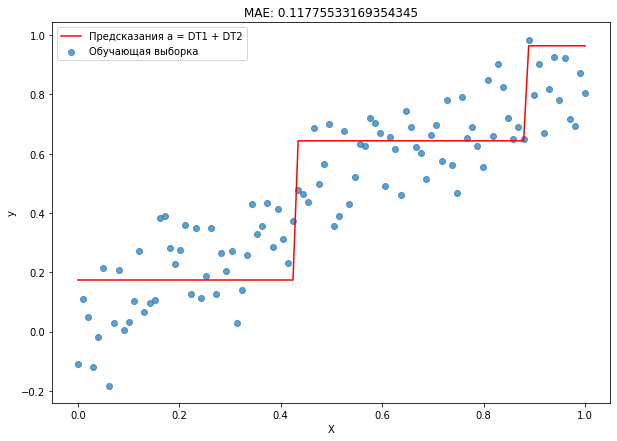

In [52]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += w * dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, 
                  y_pred_label = 'Предсказания a = DT1 + DT2', loss = 'mae')

#### 4.2 Переобучение.

Вспомним, что в случае бэггинга увеличение числа базовых моделей не приводило к переобучению. Например, в случайном лесе ошибки на тренировочной и тестовой выборках выходили на плато, начиная с какого-то числа деревьев. Понятно, что бустинг не будет обладать этим свойством *по построению*: при добавлении новых базовых моделей композиция всё точнее будет приближать обучающую выборку, что в конечном итоге (зачастую быстро) может привести к переобучению. Из этого можно сделать вывод, что в случае бустинга ошибка на обучающей выборке в зависимости от числа деревьев является убывающей функцией, а ошибка на тестовой выборке, скорее всего, имеет U-образный вид. Убедимся в этом и сравним поведение ошибок и решающих поверхностей бустинга и случайного леса. 

Здесь и далее будем использовать [реализацию бустинга](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) из `sklearn`, которая представляет собой градиентный бустинг над деревьями.

In [53]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [54]:
# Генерация выборки
np.random.seed(123)
X = np.linspace(0, 1, 300).reshape(-1, 1)

def target(a):
    return a > 0.5

y = target(X) + np.random.normal(size = X.shape) * 0.1
y = y[:, 0]

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

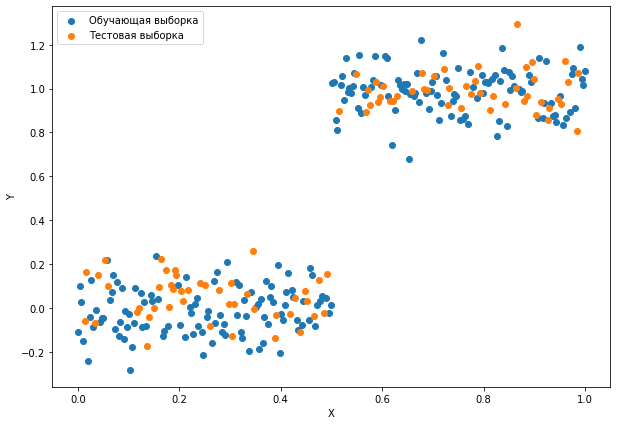

In [56]:
# Визуализация выборки
plt.figure(figsize = (10, 7))
plt.scatter(X_train, y_train, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, label = 'Тестовая выборка')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend();

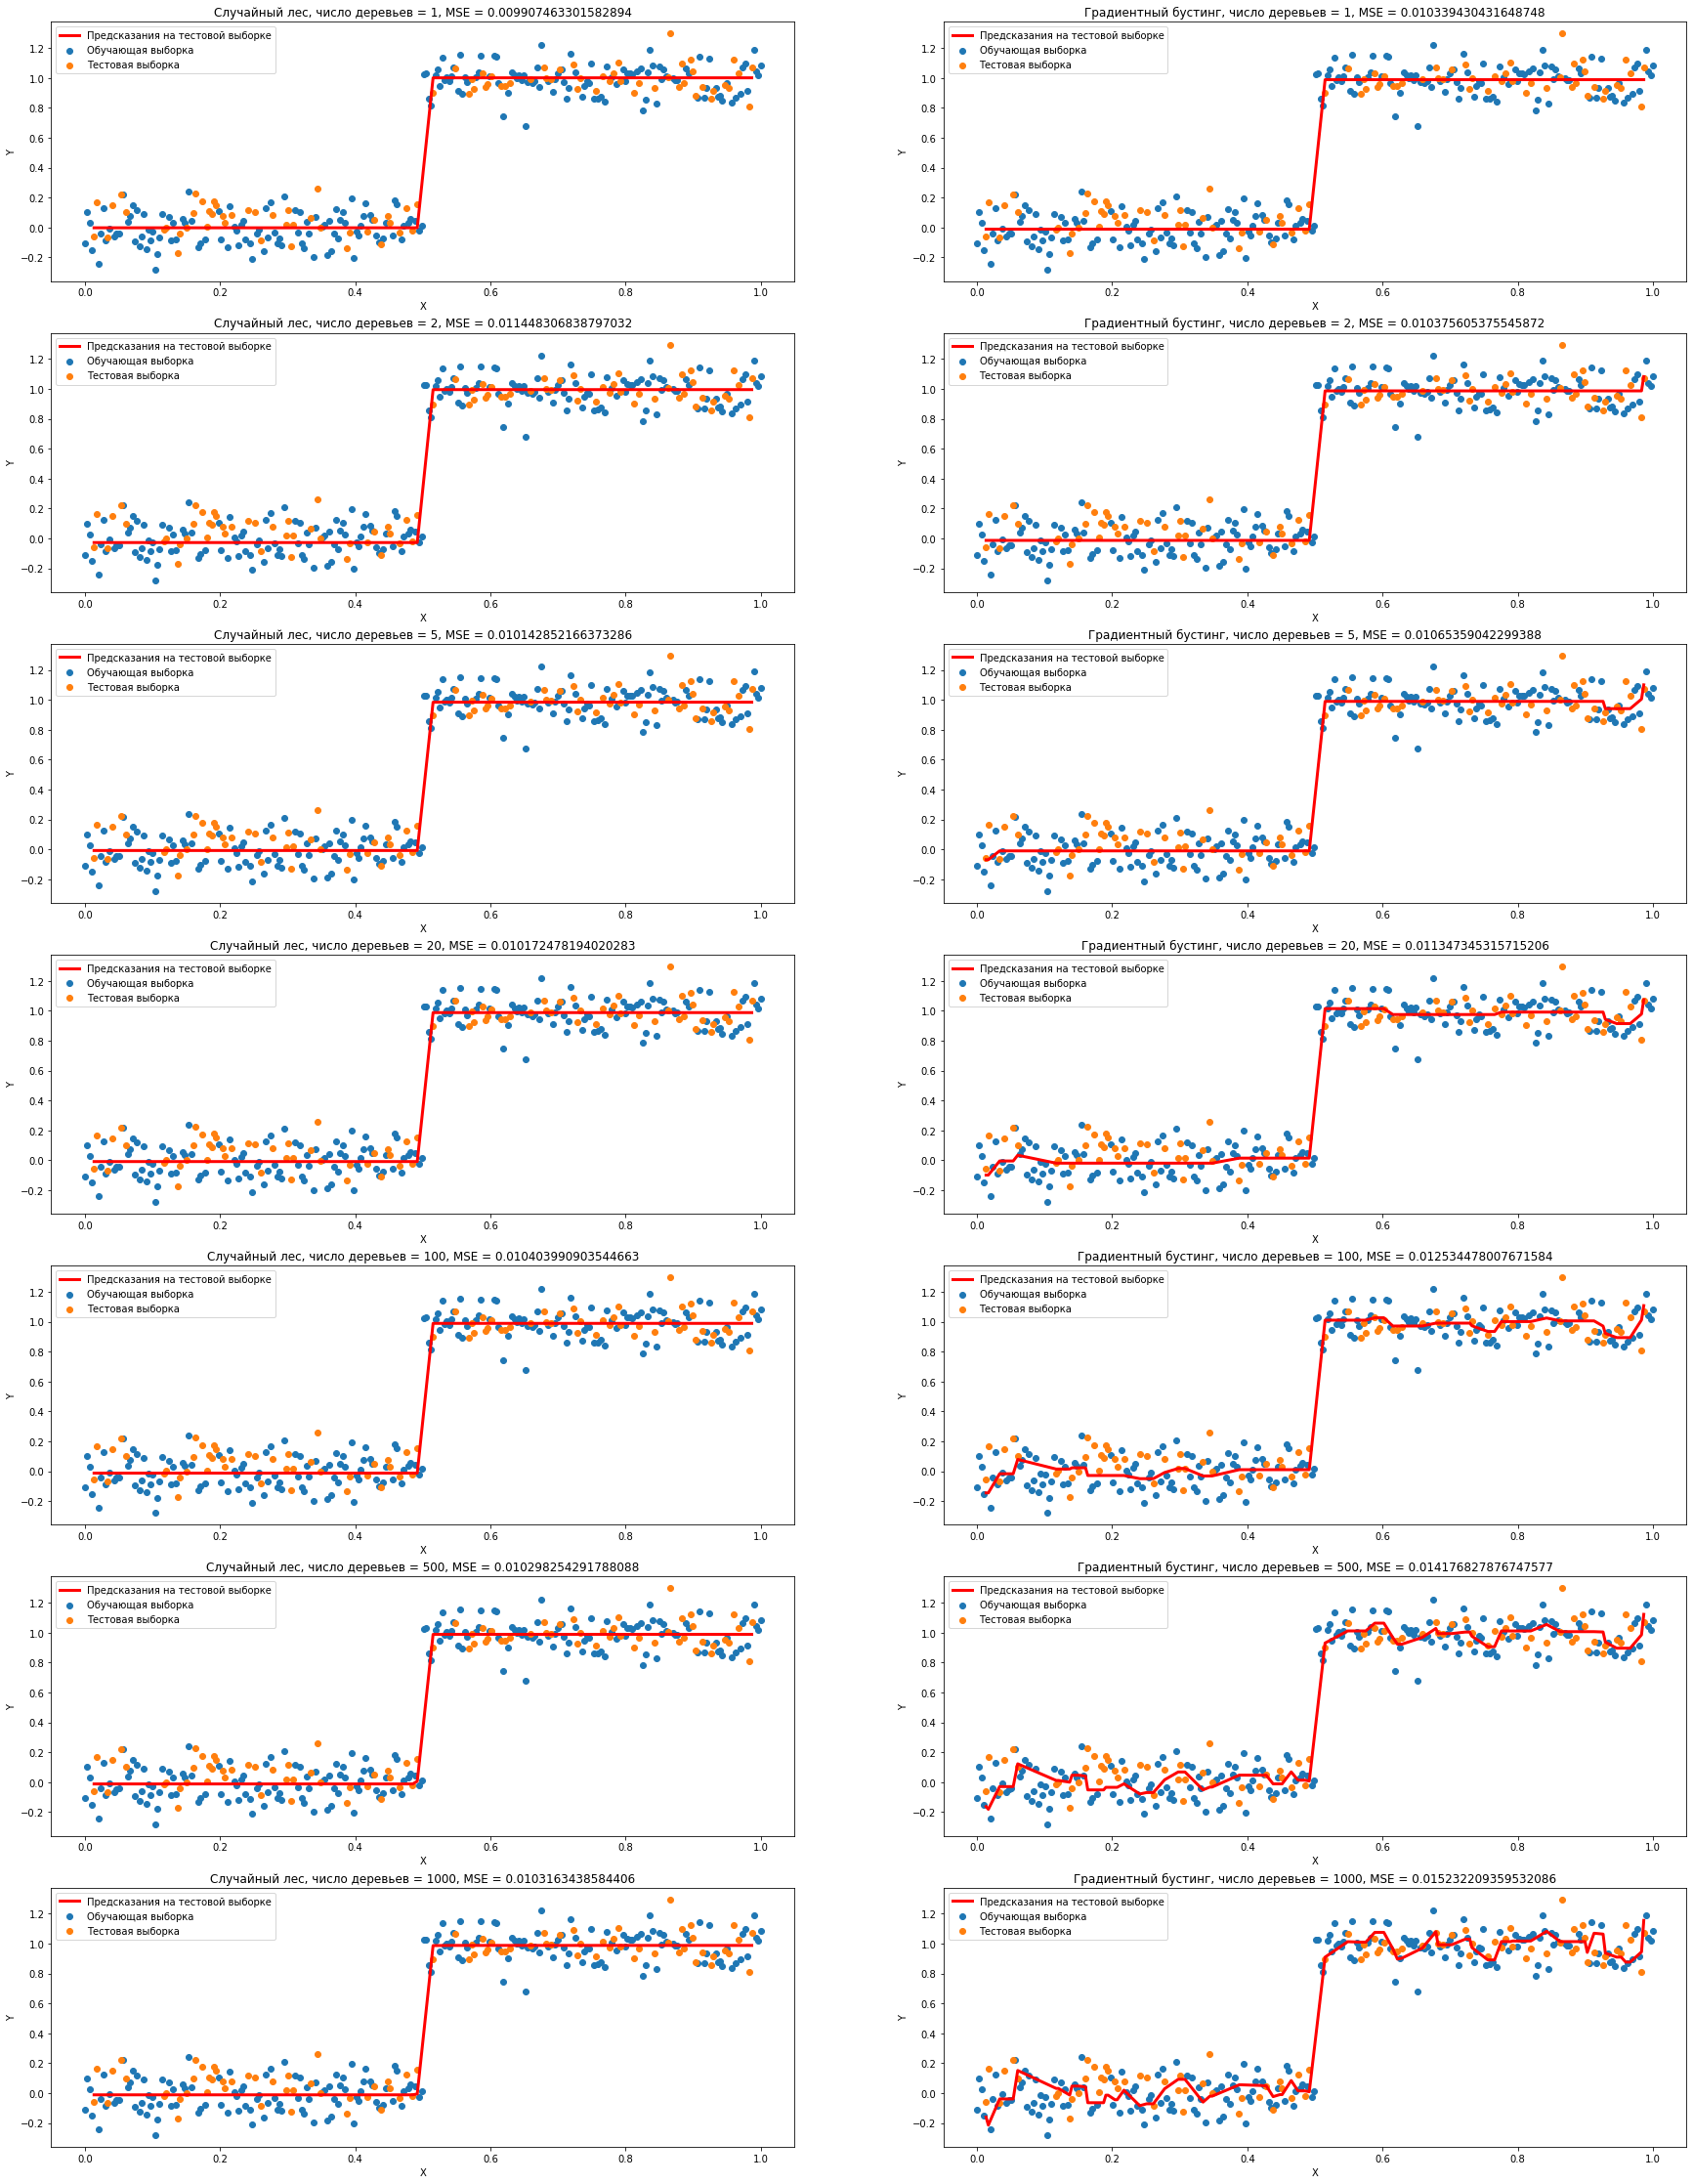

In [57]:
# Визуализация решающих поверхностей
trees = [1, 2, 5, 20, 100, 500, 1000]

fig, ax = plt.subplots(len(trees), 2, figsize = (30, 40))

loss_rf_train = []
loss_gb_train = []
loss_rf_test = []
loss_gb_test = []

for i, ts in enumerate(trees):
    rf = RandomForestRegressor(n_estimators = ts, max_depth = 1)
    gb = GradientBoostingRegressor(n_estimators = ts, max_depth = 1, learning_rate = 1)
    
    rf.fit(X_train, y_train)
    ax[i, 0].scatter(X_train, y_train, label = 'Обучающая выборка')
    ax[i, 0].scatter(X_test, y_test, label = 'Тестовая выборка')
    ax[i, 0].plot(sorted(X_test), rf.predict(sorted(X_test)), lw = 3, c = 'red', label = 'Предсказания на тестовой выборке')
    ax[i, 0].set_xlabel('X')
    ax[i, 0].set_ylabel('Y')
    ax[i, 0].set_title('Случайный лес, число деревьев = ' + str(ts) + ', MSE = ' + str(mean_squared_error(y_test, rf.predict(X_test))))
    ax[i, 0].legend();
    
    loss_rf_train.append(mean_squared_error(y_train, rf.predict(X_train)))
    loss_rf_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    
    gb.fit(X_train, y_train)
    ax[i, 1].scatter(X_train, y_train, label = 'Обучающая выборка')
    ax[i, 1].scatter(X_test, y_test, label = 'Тестовая выборка')
    ax[i, 1].plot(sorted(X_test), gb.predict(sorted(X_test)), lw = 3, c = 'red', label = 'Предсказания на тестовой выборке')
    ax[i, 1].set_xlabel('X')
    ax[i, 1].set_ylabel('Y')
    ax[i, 1].set_title('Градиентный бустинг, число деревьев = ' + str(ts) + ', MSE = ' + str(mean_squared_error(y_test, gb.predict(X_test))))
    ax[i, 1].legend();
    
    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

Как мы видим, решающая поверхность случайного леса не изменяется (уже со второго дерева), в то время как для бустинга она становится всё более сложной.

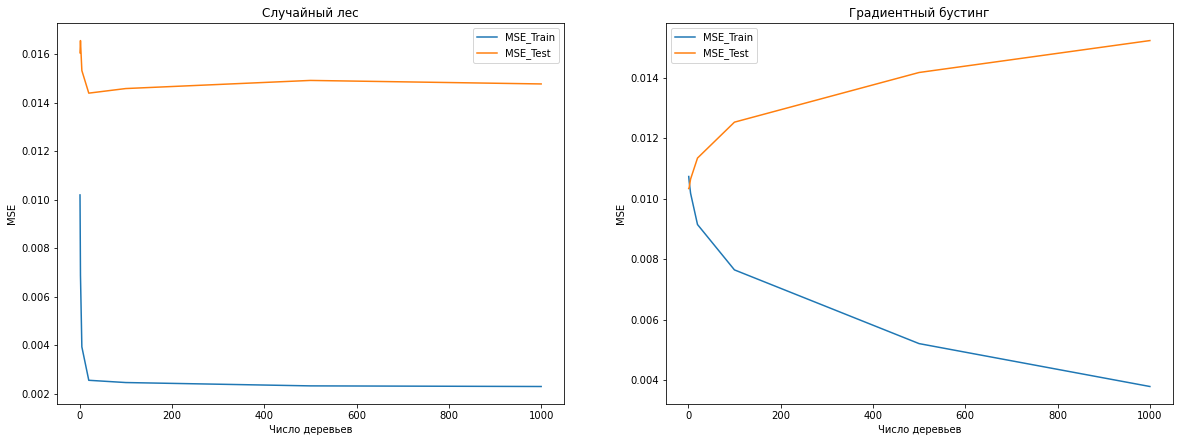

In [186]:
# Визуализация ошибок
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

ax[0].plot(trees, loss_rf_train, label = 'MSE_Train')
ax[0].plot(trees, loss_rf_test, label = 'MSE_Test')
ax[0].set_xlabel('Число деревьев')
ax[0].set_ylabel('MSE')
ax[0].set_title('Случайный лес')
ax[0].legend()

ax[1].plot(trees, loss_gb_train, label = 'MSE_Train')
ax[1].plot(trees, loss_gb_test, label = 'MSE_Test')
ax[1].set_xlabel('Число деревьев')
ax[1].set_ylabel('MSE')
ax[1].set_title('Градиентный бустинг')
ax[1].legend();

Поведение ошибок для случайного леса совпадает с тем, которое мы видели на предыдущем семинаре. В случае бустинга ошибка на тренировочной выборке стабильно убывает, а на тестовой – возрастает, что вероятно говорит об (очень быстром) переобучении. Если же мы аккуратно подберём гиперпараметры для деревьев и длину шага, то сможем добиться типичной U-образной формы функции потерь на тестовой выборке.

В качестве способа регуляризации также может использоваться сокращение шага:

$$
a^{(N)}(X) = a^{(N-1)}(X) + \alpha w_N b^{(N)}(X),
$$

где $\alpha \in (0, 1]$ – темп обучения, или стохастический градиентный бустинг.

**Важный момент:** примеры выше демонстрируют, насколько быстро бустинг может переобучаться, и как в его случае важен подбор гиперпараметров. В связи с этим может сложиться ситуация, что градиентный бустинг с дефолтными параметрами показывает более плохое качество, чем, например, случайный лес с дефолтными параметрами, однако хорошо настроенный градиентный бустинг [обычно превосходит](https://www.quora.com/How-can-the-performance-of-a-Gradient-Boosting-Machine-be-worse-than-Random-Forests) случайный лес по качеству. Важна и конкретная реализация бустинга: например, [здесь](https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956), представлено очень хорошее сравнение различных имплементаций. 

#### 4.3 Пара слов о смещении и дисперсии.

Вспомним, что в случайном лесе в качестве базовых моделей мы брали переобученные деревья, мотивируя это тем, что бэггинг позволит сохранить низкое смещение и при этом уменьшить дисперсию. Бустинг по построению работает проивоположно: композиция обладает более низким, чем базовые модели, смещением, но такой же или большей дисперсией (ещё раз проговорите последовательность построения бустинга, и вы увидите, почему это так). Поэтому в качестве базовых моделей для бустинга обычно используются модели с высоким смещением и низкой дисперсией – как мы знаем, такие модели являются недообученными – например, неглубокие решающие деревья.

### 5. Тестирование градиентного бустинга на разных данных

На прошлом семинаре мы выяснили, что случайный лес с дефолтными гиперпараметрами превосходит другие изученные нами алгоритмы на разных типах данных. Попробуем на тех же данных сравнить случайный лес и градиентный бустинг. 

**Важное замечание:** скорее всего, бустинг с дефолтными гиперпараметрами будет показывать более плохое качество, чем случайный лес с дефолтными гиперпараметрами – ключевую роль в бустинге играет подбор гиперпараметров. В дополнение, сравнение различных имплементаций по ссылке выше показывает, что реализация `sklearn` может оказаться не самой удачной по качеству (спорный вопрос!). Поэтому попробуйте провести как можно больше экспериментов и подобрать такие гиперпараметры для бустинга, чтобы превзойти случайный лес по качеству.

**Внимание:** в этой части вам предстоит скачивать объёмные наборы данных. Не забудьте удалить их после семинара, если не планируете использовать их в дальнейшем, чтобы они не занимали лишнее место на вашем компьютере.

**! Модели могут обучаться очень-очень долго.**

#### 5.1 Бинарная классификация на примере [Kaggle Predicting a Biological Response](https://www.kaggle.com/c/bioresponse/data?select=train.csv)

In [58]:
# Загрузка данных
!wget  -O 'kaggle_response.csv' -q 'https://www.dropbox.com/s/uha70sej5ugcrur/_train_sem09.csv?dl=1'

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [64]:
data = pd.read_csv('_train_sem09.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [66]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score

# TODO: обучите градиентный бустинг и случайный лес с дефолтными параметрами
# Сравните их AUC ROC на тестовой выборке

s2 = y - a

# TODO: обучите третье решающее дерево глубины 1, предсказывающее остатки
gb = GradientBoostingClassifier(max_depth = 1)
gb.fit(X, s2)

# TODO: сделайте предсказания на обучающей выборке
pred_gb = gb.predict(X)

# TODO: включите предсказания третьего дерева в композицию (простым суммированием)
a += pred_gb

# Получение предсказаний на обучающей выборке
pred_gb = gb.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)

# TODO: попробуйте настроить градиентный бустинг так, чтобы превзойти случайный лес по качеству



ValueError: operands could not be broadcast together with shapes (3751,) (100,) 

In [305]:
roc_auc_score(y_test, pred_gb[:, 1])

0.8764019226367591

In [306]:
roc_auc_score(y_test, pred_rf[:, 1])

0.8753020014750388

#### 5.2 Изображения на примере [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [200]:
# Загрузка данных
import torchvision

fmnist = torchvision.datasets.FashionMNIST('./', download = True)
X = fmnist.data.numpy().reshape(-1, 28 * 28)
y = fmnist.targets.numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [201]:
from sklearn.metrics import accuracy_score

# TODO: обучите градиентный бустинг и случайный лес с дефолтными параметрами
# Сравните их доли правильных ответов на тестовой выборке


# TODO: попробуйте настроить градиентный бустинг так, чтобы превзойти случайный лес по качеству



In [202]:
accuracy_score(y_test, pred_gb)

0.6829444444444445

In [203]:
accuracy_score(y_test, pred_rf)

0.8441111111111111

#### 5.3 Тексты на примере бинарной классификации твитов из семинара 10

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [204]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler

# Предобработка из семинара 10
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = 'positive'
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = 'negative'
df = positive.append(negative)

X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, random_state=13)

vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

X_train = bow
X_test = bow_test

In [205]:
# TODO: обучите градиентный бустинг с дефолтными параметрами
# и случайный лес с числом деревьев 100 и макс. глубиной дерева 20 
# Сравните их доли правильных ответов на тестовой выборке


# TODO: попробуйте настроить градиентный бустинг так, чтобы превзойти случайный лес по качеству



In [206]:
accuracy_score(y_test, pred_gb)

0.5812304925144157

In [207]:
accuracy_score(y_test, pred_rf)

0.629829480329401